<a href="https://colab.research.google.com/github/abulhasanat/MachineLearning/blob/master/fbprophet_part_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [0]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

## Read in the data

In [0]:
sales_df = pd.read_csv('/content/drive/My Drive/Training data/fbprophet/retail_sales.csv', index_col='date', parse_dates=True)

In [44]:
sales_df.head()

,sales
date,
2019-10-30,6.318787e+06
2019-11-07,7.702524e+06
2019-09-08,1.155229e+07
2020-01-20,5.588498e+06
2020-02-16,1.065042e+07


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (we'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [0]:
df = sales_df.reset_index()

In [46]:
df.head()

,date,sales
0,2019-10-30,6.318787e+06
1,2019-11-07,7.702524e+06
2,2019-09-08,1.155229e+07
3,2020-01-20,5.588498e+06
4,2020-02-16,1.065042e+07


Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [0]:
df=df.rename(columns={'date':'ds', 'sales':'y'})

In [48]:
df.head()

,ds,y
0,2019-10-30,6.318787e+06
1,2019-11-07,7.702524e+06
2,2019-09-08,1.155229e+07
3,2020-01-20,5.588498e+06
4,2020-02-16,1.065042e+07


Now's a good time to take a look at your data. Plot the data using pandas' plot function

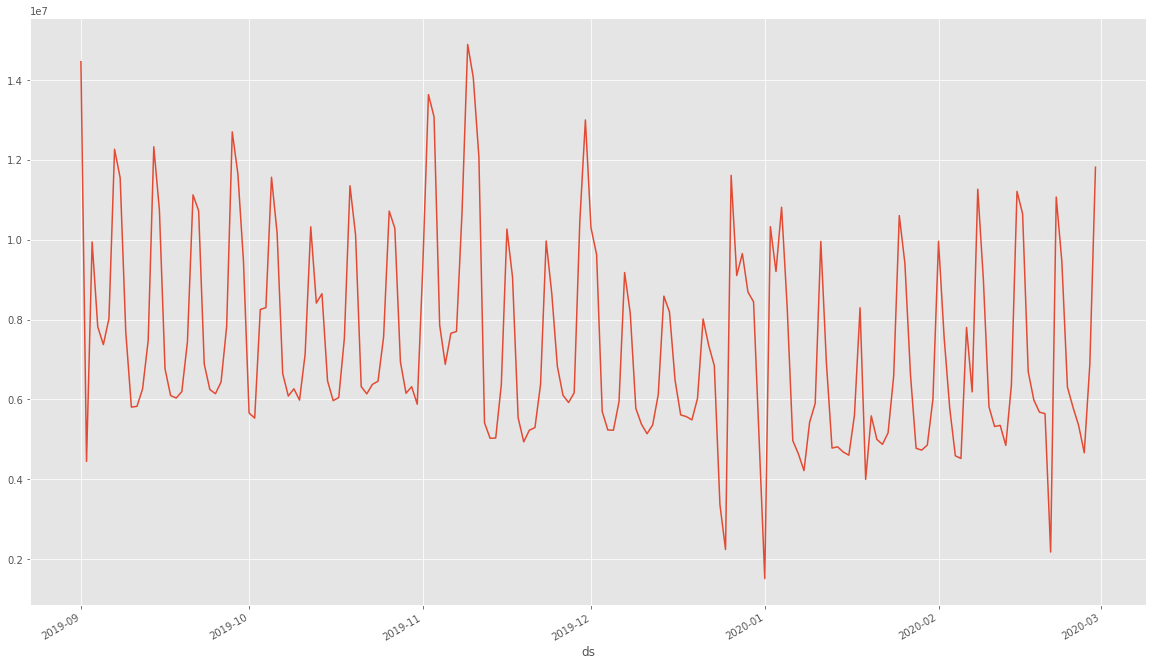

In [49]:
plt.figure(figsize=(20, 12))
df.set_index('ds').y.plot()


When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now. Taking the log of a number is easily reversible to be able to see your original data.

In [0]:
df['y'] = np.log(df['y'])

In [51]:
df.tail()

,ds,y
177,2020-02-07,15.638181
178,2019-10-12,16.150156
179,2019-12-26,16.267702
180,2019-11-06,15.851087
181,2019-11-26,15.624592


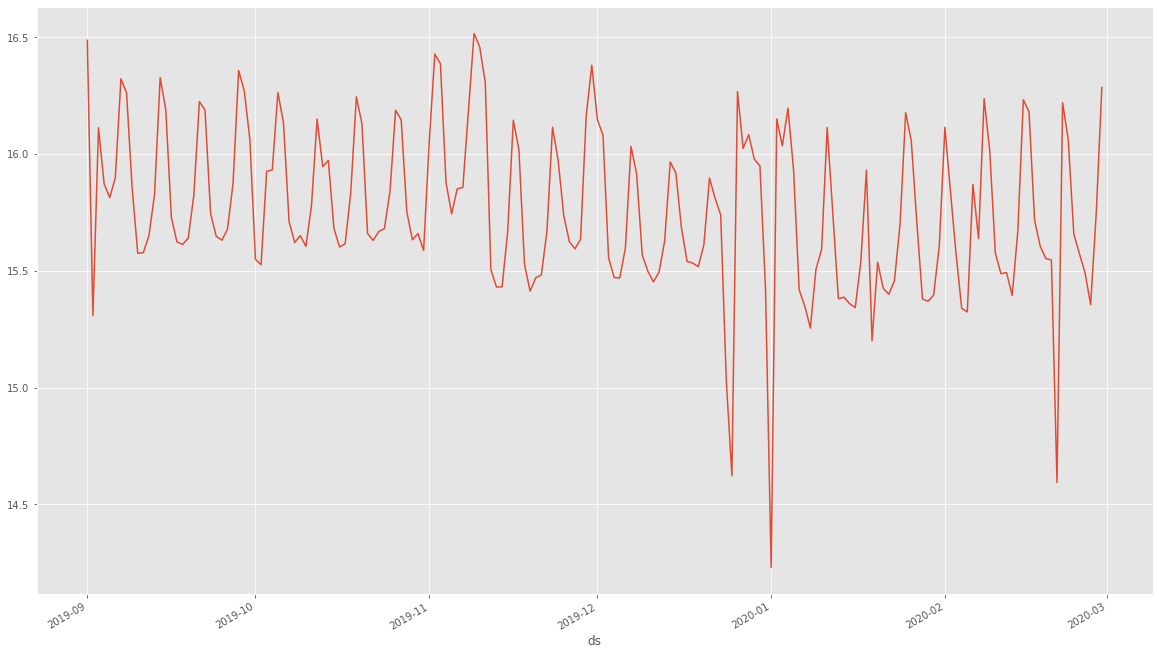

In [52]:
plt.figure(figsize=(20, 12))
df.set_index('ds').y.plot()

As you can see in the above chart, the plot looks the same as the first one but just at a different scale.

# Running Prophet
Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this. This is OK since we are workign with monthly data but you can disable it by using weekly_seasonality=True in the instantiation of Prophet.

Running Prophet

In [0]:
model = Prophet(yearly_seasonality=True,daily_seasonality=True)
model.fit(df);


Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the freq='m' inclusion to ensure we are adding 24 months of data.

This can be done with the following code:

In [54]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
201,2021-10-31
202,2021-11-30
203,2021-12-31
204,2022-01-31
205,2022-02-28



To forecast this future data, we need to run it through Prophet's model.

In [0]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns. First, let's look at the full dataframe:

In [56]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
201,2021-10-31,15.583690,15.266620,15.813092,15.583681,15.583698,-0.037245,-0.037245,-0.037245,-0.475776,-0.475776,-0.475776,0.287531,0.287531,0.287531,0.151001,0.151001,0.151001,0.0,0.0,0.0,15.546445
202,2021-11-30,15.554576,14.568520,15.073485,15.554566,15.554585,-0.727999,-0.727999,-0.727999,-0.475776,-0.475776,-0.475776,-0.227159,-0.227159,-0.227159,-0.025063,-0.025063,-0.025063,0.0,0.0,0.0,14.826577
203,2021-12-31,15.524492,14.653992,15.203195,15.524482,15.524502,-0.589614,-0.589614,-0.589614,-0.475776,-0.475776,-0.475776,-0.010748,-0.010748,-0.010748,-0.103090,-0.103090,-0.103090,0.0,0.0,0.0,14.934878
204,2022-01-31,15.494408,14.665107,15.186411,15.494397,15.494419,-0.572793,-0.572793,-0.572793,-0.475776,-0.475776,-0.475776,-0.040899,-0.040899,-0.040899,-0.056117,-0.056117,-0.056117,0.0,0.0,0.0,14.921616
205,2022-02-28,15.467235,14.792724,15.330336,15.467224,15.467246,-0.409735,-0.409735,-0.409735,-0.475776,-0.475776,-0.475776,-0.040899,-0.040899,-0.040899,0.106940,0.106940,0.106940,0.0,0.0,0.0,15.057500


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [57]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
201,2021-10-31,15.546445,15.266620,15.813092
202,2021-11-30,14.826577,14.568520,15.073485
203,2021-12-31,14.934878,14.653992,15.203195
204,2022-01-31,14.921616,14.665107,15.186411
205,2022-02-28,15.057500,14.792724,15.330336



## Plotting Prophet results
Prophet has a plotting mechanism called plot. This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

<Figure size 1440x864 with 0 Axes>

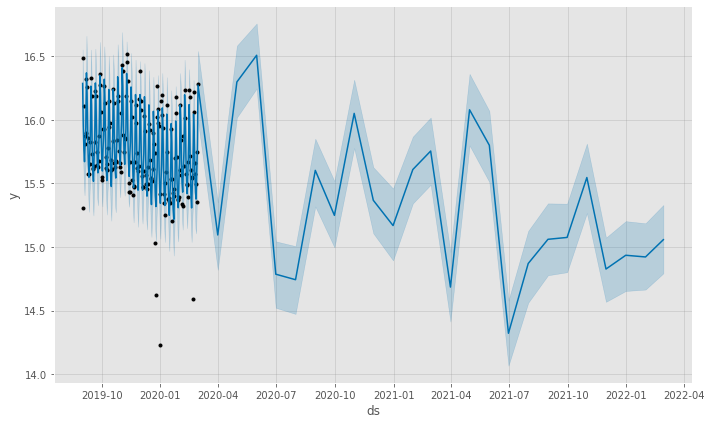

In [58]:
plt.figure(figsize=(20, 12))
model.plot(forecast);


Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself. The next section describes how I build my own visualization for Prophet modeling

## Visualizing Prophet models
In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ds

In [0]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [0]:
viz_df = sales_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

If we look at the head(), we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's exp function to do that.

In [61]:
viz_df.head()

,sales,yhat,yhat_lower,yhat_upper
2019-09-01,1.446144e+07,16.286834,16.017400,16.554085
2019-09-02,4.447668e+06,15.958839,15.670369,16.195461
2019-09-03,9.945977e+06,15.767013,15.497095,16.041842
2019-09-04,7.823547e+06,15.671033,15.406582,15.947586
2019-09-05,7.372518e+06,15.836986,15.562693,16.117572


In [0]:
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

In [63]:
viz_df.head()

,sales,yhat,yhat_lower,yhat_upper,yhat_rescaled
2019-09-01,1.446144e+07,16.286834,16.017400,16.554085,1.183810e+07
2019-09-02,4.447668e+06,15.958839,15.670369,16.195461,8.527773e+06
2019-09-03,9.945977e+06,15.767013,15.497095,16.041842,7.039254e+06
2019-09-04,7.823547e+06,15.671033,15.406582,15.947586,6.395036e+06
2019-09-05,7.372518e+06,15.836986,15.562693,16.117572,7.549459e+06


Let's take a look at the sales and yhat_rescaled data together in a chart.

<Figure size 1440x864 with 0 Axes>

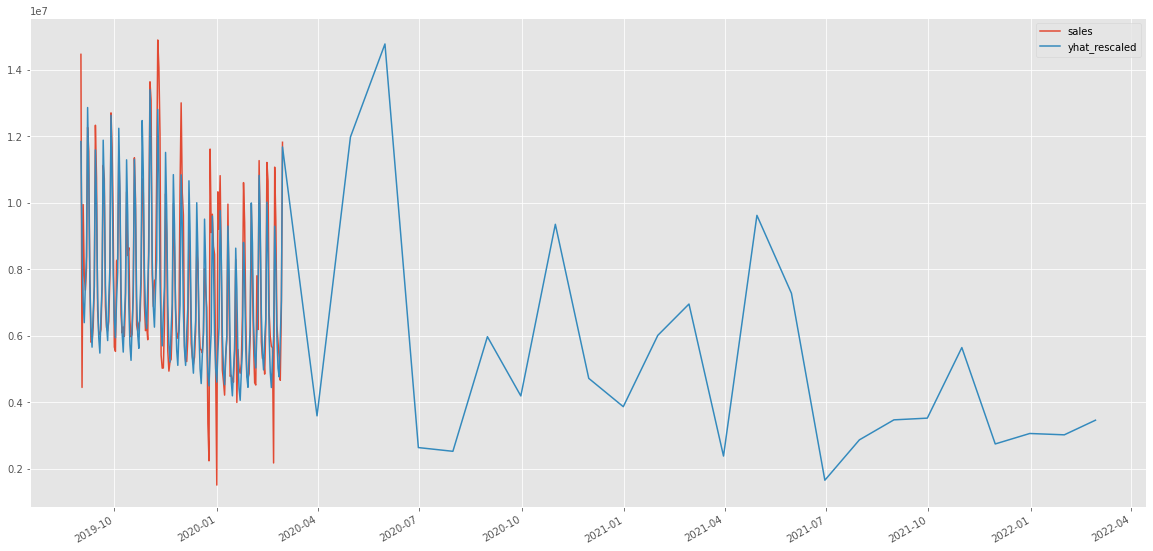

In [64]:
plt.figure(figsize=(20, 12))
viz_df[['sales', 'yhat_rescaled']].plot()

You can see from the chart that the model (blue) is pretty good when plotted against the actual signal (orange) but I like to make my vizualization's a little better to understand. To build my 'better' visualization, we'll need to go back to our original sales_df and forecast dataframes.

First things first - we need to find the 2nd to last date of the original sales data in sales_df in order to ensure the original sales data and model data charts are connected.

In [0]:
# pd.to_datetime(sales_df.index).max()

In [0]:
sales_df.index = pd.to_datetime(sales_df.index) #make sure our index as a datetime object
# connect_date = sales_df.index[-2] #select the 2nd to last date
connect_date=pd.to_datetime(sales_df.index).max()

Using the connect_date we can now grab only the model data that after that date (you'll see why in a minute). To do this, we'll mask the forecast data.

In [0]:
mask = (forecast.index >= connect_date)
predict_df = forecast.loc[mask]

In [90]:
predict_df.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-02-29,16.175665,15.993669,16.541544,16.175665,16.175665,0.097614,0.097614,0.097614,-0.475776,-0.475776,-0.475776,0.436257,0.436257,0.436257,0.137133,0.137133,0.137133,0.0,0.0,0.0,16.273279
2020-03-31,16.145581,14.820116,15.352618,16.145581,16.145581,-1.051080,-1.051080,-1.051080,-0.475776,-0.475776,-0.475776,-0.227159,-0.227159,-0.227159,-0.348144,-0.348144,-0.348144,0.0,0.0,0.0,15.094501
2020-04-30,16.116468,16.018434,16.583557,16.116467,16.116468,0.181878,0.181878,0.181878,-0.475776,-0.475776,-0.475776,-0.132345,-0.132345,-0.132345,0.790000,0.790000,0.790000,0.0,0.0,0.0,16.298346
2020-05-31,16.086384,16.246496,16.758158,16.086383,16.086384,0.421982,0.421982,0.421982,-0.475776,-0.475776,-0.475776,0.287531,0.287531,0.287531,0.610228,0.610228,0.610228,0.0,0.0,0.0,16.508366
2020-06-30,16.057270,14.521752,15.044213,16.057269,16.057271,-1.271282,-1.271282,-1.271282,-0.475776,-0.475776,-0.475776,-0.227159,-0.227159,-0.227159,-0.568347,-0.568347,-0.568347,0.0,0.0,0.0,14.785988


Now, let's build a dataframe to use in our new visualization. We'll follow the same steps we did before.

In [0]:
viz_df = sales_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])

Now, if we take a look at the head() of viz_df we'll see 'NaN's everywhere except for our original data rows.

In [92]:
viz_df.head()

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2019-09-01,1.446144e+07,NaN,NaN,NaN,NaN
2019-09-02,4.447668e+06,NaN,NaN,NaN,NaN
2019-09-03,9.945977e+06,NaN,NaN,NaN,NaN
2019-09-04,7.823547e+06,NaN,NaN,NaN,NaN
2019-09-05,7.372518e+06,NaN,NaN,NaN,NaN


If we take a look at the tail() of the viz_df you'll see we have data for the forecasted data and NaN's for the original data series.

In [93]:
viz_df.tail()

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2021-10-31,NaN,15.546445,15.266620,15.813092,5.645926e+06
2021-11-30,NaN,14.826577,14.568520,15.073485,2.748530e+06
2021-12-31,NaN,14.934878,14.653992,15.203195,3.062916e+06
2022-01-31,NaN,14.921616,14.665107,15.186411,3.022563e+06
2022-02-28,NaN,15.057500,14.792724,15.330336,3.462497e+06



# time to plot
Now, let's plot everything to get the 'final' visualization of our sales data and forecast with errors.

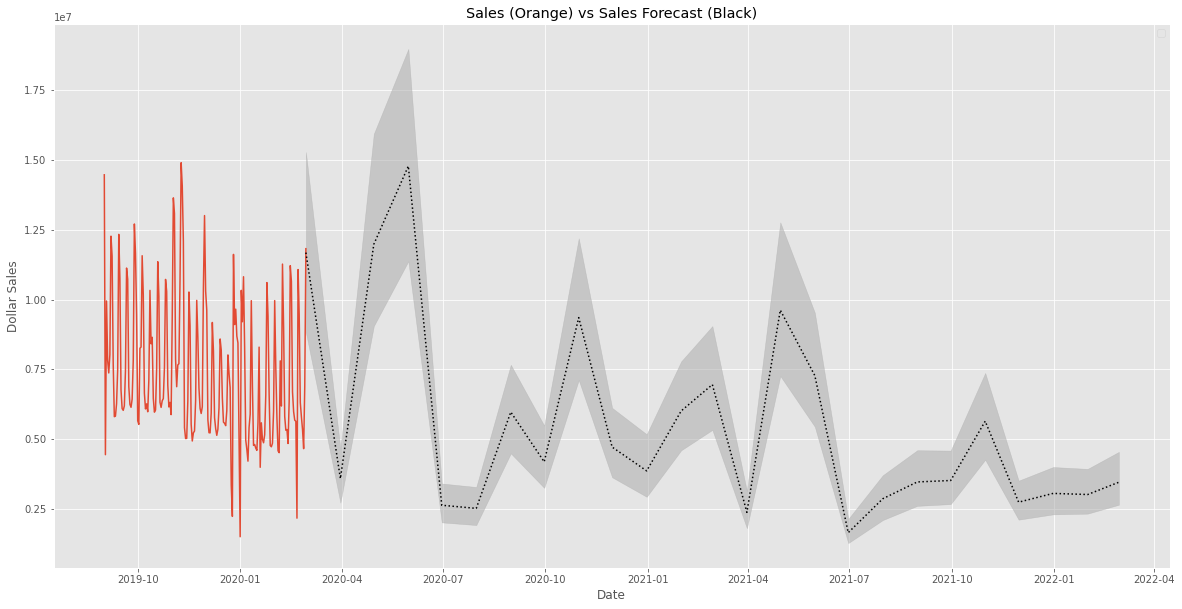

<Figure size 1440x864 with 0 Axes>

In [94]:
fig, ax1 = plt.subplots()
plt.figure(figsize=(20, 12))
ax1.plot(viz_df.sales)
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (Orange) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
# L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
# L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot


This visualization is much better (in my opinion) than the default fbprophet plot. It is much easier to quickly understand and describe what's happening. The orange line is actual sales data and the black dotted line is the forecast. The gray shaded area is the uncertaintity estimation of the forecast.